# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.269430,False,0.362230
1,-0.082544,False,-0.767772
2,-1.814006,False,-0.707189
3,-1.449714,False,-1.707053
4,0.996700,True,2.920611
...,...,...,...
995,-1.426200,False,-1.152158
996,0.799952,True,5.970946
997,0.336987,True,7.368024
998,-1.835364,False,-0.493349


<Axes: xlabel='v0'>

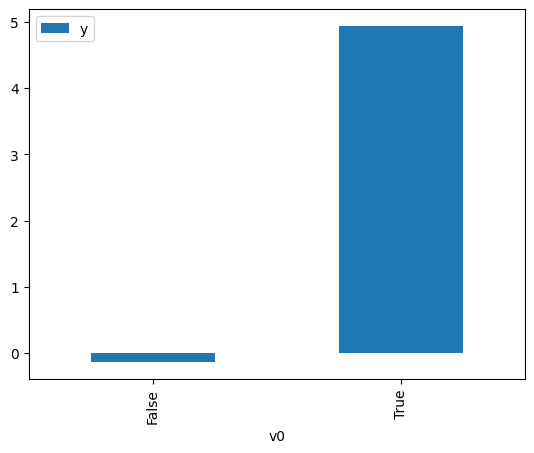

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

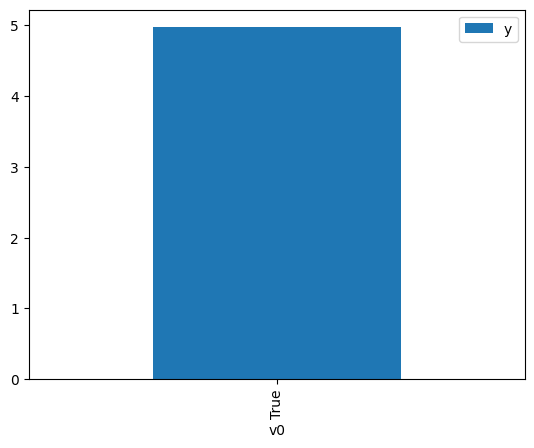

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.678214,False,0.638137,0.377125,2.651638
1,0.790310,False,-0.069697,0.358504,2.789370
2,0.641499,False,-0.379419,0.383307,2.608872
3,0.031219,False,-0.845857,0.490134,2.040257
4,0.090265,False,-0.439085,0.479597,2.085085
...,...,...,...,...,...
995,-0.001491,False,-0.046452,0.495976,2.016226
996,-0.504713,False,-0.992955,0.585034,1.709302
997,-0.092837,False,-1.266626,0.512291,1.952015
998,-1.253501,False,-0.125889,0.706513,1.415403


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.112066,True,4.564782,0.524290,1.907342
1,-1.671744,True,4.628525,0.235528,4.245780
2,0.679911,True,6.201627,0.623159,1.604726
3,-1.633031,True,5.480536,0.240545,4.157226
4,0.003191,True,7.543041,0.504860,1.980747
...,...,...,...,...,...
995,0.186091,True,3.327907,0.537462,1.860597
996,0.533387,True,5.117317,0.598275,1.671472
997,-0.211352,True,3.773451,0.466586,2.143230
998,-0.150743,True,5.005458,0.477378,2.094776


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.920
Method:                 Least Squares   F-statistic:                              5714.
Date:                Sat, 15 Nov 2025   Prob (F-statistic):                        0.00
Time:                        06:22:50   Log-Likelihood:                         -1429.1
No. Observations:                1000   AIC:                                      2862.
Df Residuals:                     998   BIC:                                      2872.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1671      0.031      5.380      0.000       0.106       0.228
x2             5.0148      0.047    106.327      0.000       4.922       5.107
==============================================================================
Omnibus:                        0.243   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.885   Jarque-Bera (JB):                0.320
Skew:                          -0.024   Prob(JB):                        0.852
Kurtosis:                       2.927   Cond. No.                         1.52
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""